In [2]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
sys.path.append('../')
sys.path.append('../utils/')
import feedforward_robust as ffr
import ipdb
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

#Read the counter
ctr_file = "counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#Setup - Dataset stuff
dataset, input_shape, num_classes = get_dataset()
x_train_flat, y_train = dataset[0] 
x_test_flat, y_test = dataset[1] 
hidden_sizes = [32,32,32,32,32,32,32]

In [5]:
x_train_flat.shape

(60000, 784)

### Trying out different corruptions 

In [6]:
paths = np.load("paths_regularized.npy", allow_pickle = True)

In [7]:
paths

array(defaultdict(<class 'list'>, {'non_robust': ['weights/model_375.ckpt', 'weights/model_381.ckpt', 'weights/model_387.ckpt', 'weights/model_393.ckpt', 'weights/model_399.ckpt', 'weights/model_405.ckpt', 'weights/model_411.ckpt', 'weights/model_417.ckpt'], 'l1': ['weights/model_376.ckpt', 'weights/model_382.ckpt', 'weights/model_388.ckpt', 'weights/model_394.ckpt', 'weights/model_400.ckpt', 'weights/model_406.ckpt', 'weights/model_412.ckpt', 'weights/model_418.ckpt'], 'op': ['weights/model_377.ckpt', 'weights/model_383.ckpt', 'weights/model_389.ckpt', 'weights/model_395.ckpt', 'weights/model_401.ckpt', 'weights/model_407.ckpt', 'weights/model_413.ckpt', 'weights/model_419.ckpt'], 'trace_first': ['weights/model_378.ckpt', 'weights/model_384.ckpt', 'weights/model_390.ckpt', 'weights/model_396.ckpt', 'weights/model_402.ckpt', 'weights/model_408.ckpt', 'weights/model_414.ckpt', 'weights/model_420.ckpt'], 'trace_all': ['weights/model_379.ckpt', 'weights/model_385.ckpt', 'weights/model_391

In [8]:
paths.item()

defaultdict(list,
            {'non_robust': ['weights/model_375.ckpt',
              'weights/model_381.ckpt',
              'weights/model_387.ckpt',
              'weights/model_393.ckpt',
              'weights/model_399.ckpt',
              'weights/model_405.ckpt',
              'weights/model_411.ckpt',
              'weights/model_417.ckpt'],
             'l1': ['weights/model_376.ckpt',
              'weights/model_382.ckpt',
              'weights/model_388.ckpt',
              'weights/model_394.ckpt',
              'weights/model_400.ckpt',
              'weights/model_406.ckpt',
              'weights/model_412.ckpt',
              'weights/model_418.ckpt'],
             'op': ['weights/model_377.ckpt',
              'weights/model_383.ckpt',
              'weights/model_389.ckpt',
              'weights/model_395.ckpt',
              'weights/model_401.ckpt',
              'weights/model_407.ckpt',
              'weights/model_413.ckpt',
              'weights/model_419.c

In [9]:
non_rob_list = paths.item()['non_robust']

In [10]:
def load_many_models_regular(weights_path):
    
    model_list = []
    sess_list = []
    for path in weights_path:
        config = {}
        config['eps_train'] = 0.1
        config['eps_test'] = 0.1
        config['tensorboard_dir'] = "tb/"
        config['weights_dir'] = "weights_new/"

        config['load_counter'] = path
        config['write_counter'] = counter
        config['sigma'] = tf.nn.relu
        config['epochs'] = 10
        config['reg_op'] = 0.0
        config['reg_l1'] = 0.0
        config['reg_trace_first'] = 0.0
        config['reg_trace_all'] = 0.0

        config['lr'] = 3e-4

        config['scope_name'] = "model_non_robust"
        config['should_load'] = True
        config['logger'] = logger
        model, sess, path = regular_training(config)
        model_list.append(model)
        sess_list.append(sess)
    return model_list, sess_list

In [11]:
def load_many_models_adv(weights_path):
    
    model_list = []
    sess_list = []
    for path in weights_path:
        config = {}
        config['eps_train'] = 0.1
        config['eps_test'] = 0.1
        config['tensorboard_dir'] = "tb/"
        config['weights_dir'] = "weights_new/"

        config['load_counter'] = path
        config['write_counter'] = counter
        config['sigma'] = tf.nn.relu
        config['epochs'] = 10
        config['reg_op'] = 0.0
        config['reg_l1'] = 0.0
        config['reg_trace_first'] = 0.0
        config['reg_trace_all'] = 0.0

        config['lr'] = 3e-4

        config['scope_name'] = "model_robust"
        config['should_load'] = True
        config['logger'] = logger
        model, sess, path = regular_training(config)
        model_list.append(model)
        sess_list.append(sess)
    return model_list, sess_list

In [12]:
def get_complexitites_many_models_reg(model_list, sess_list, x_test, y_test):
    spectral_list = []
    fr_list = []
    lipschitzness_average = []

    for idx, model in enumerate(model_list):
        print(idx)
        with tf.variable_scope("model_non_robust", reuse = tf.AUTO_REUSE) as scope:
            sess = sess_list[idx]
            spectral_norm = model.get_spectral_norm(sess)
            spectral_list.append(spectral_norm)
            fr_norm = model.get_fisher_rao_norm_squared(sess, x_test, y_test)
            fr_list.append(fr_norm)
            
            print("Lip start")
            dphi_dx_test = model.get_dphi_dx(sess, x_test_flat)[0]
            lipschitzness_average.append(np.mean(np.abs(dphi_dx_test)))
            #model.evaluate(sess, x_test, y_test)
    return spectral_list, fr_list, lipschitzness_average

In [13]:
def get_complexitites_many_models_adv(model_list, sess_list, x_test, y_test):
    spectral_list = []
    fr_list = []
    lipschitzness_average = []
    
    for idx, model in enumerate(model_list):
        print(idx)
        with tf.variable_scope("model_robust", reuse = tf.AUTO_REUSE) as scope:
            sess = sess_list[idx]
            spectral_norm = model.get_spectral_norm(sess)
            spectral_list.append(spectral_norm)
            fr_norm = model.get_fisher_rao_norm_squared(sess, x_test, y_test)
            fr_list.append(fr_norm)
            
            print("Lip start")
            dphi_dx_test = model.get_dphi_dx(sess, x_test_flat)[0]
            lipschitzness_average.append(np.mean(np.abs(dphi_dx_test)))
            
            #model.evaluate(sess, x_test, y_test)
    return spectral_list, fr_list, lipschitzness_average

In [14]:
#TODOS:
#1. Black Box Perturbations - NOW
#2. Margins/Lipschitzness
#4. Distances - SKIP (Too slow)
#3. Singular Values - SKIP

## Regular Training Run Test

In [15]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights_new/"

config['load_counter'] = non_rob_list[0]
config['write_counter'] = counter
config['sigma'] = tf.nn.relu
config['epochs'] = 10
config['reg_op'] = 0.0
config['reg_l1'] = 0.0
config['reg_trace_first'] = 0.0
config['reg_trace_all'] = 0.0

config['lr'] = 3e-4

config['scope_name'] = "model_non_robust"
config['should_load'] = True
config['logger'] = logger

In [16]:
tf.reset_default_graph()

In [17]:
#model_hybrid, sess_hybrid, = regular_training(config)
model, sess, path = regular_training(config)

Initialized instance variables of the robust model class
Created placeholders for x and y


Instructions for updating:
Colocations handled automatically by placer.


Created layers and tensor for logits


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from weights/model_375.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2021035, 0.9609)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2021035, 0.9609)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(25.648188, 0.0732)


In [19]:
with tf.variable_scope("model_non_robust", reuse = tf.AUTO_REUSE) as scope:
    spectral_norm = model.get_spectral_norm(sess)

In [20]:
spectral_norm

2802957.6085055773

# Regular Training

In [21]:
weights_path_non_rob = paths.item()['non_robust']

In [22]:
weights_path_non_rob

['weights/model_375.ckpt',
 'weights/model_381.ckpt',
 'weights/model_387.ckpt',
 'weights/model_393.ckpt',
 'weights/model_399.ckpt',
 'weights/model_405.ckpt',
 'weights/model_411.ckpt',
 'weights/model_417.ckpt']

In [23]:
non_rob_models, non_rob_sess_list = load_many_models_regular(weights_path_non_rob)

Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_375.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2021035, 0.9609)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2021035, 0.9609)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(25.648188, 0.0732)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_381.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.18299215, 0.9648)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.18299215, 0.9648)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(23.44191, 0.0788)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_387.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2028705, 0.9614)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2028705, 0.9614)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(25.644579, 0.0501)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_393.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.19511902, 0.963)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.19511902, 0.963)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(21.7764, 0.083)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_399.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.1965558, 0.961)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.1965558, 0.961)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(21.579971, 0.0654)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_405.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.18205819, 0.9623)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.18205819, 0.9623)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(21.159979, 0.1318)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_411.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.19011636, 0.9643)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.19011636, 0.9643)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(23.32506, 0.0393)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_417.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.19717272, 0.9621)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.19717272, 0.9621)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(22.460144, 0.0547)


In [28]:
model_test, sess_test = non_rob_models[0], non_rob_sess_list[0]
with tf.variable_scope("model_non_robust", reuse = tf.AUTO_REUSE) as scope:
    pw_margins = model_test.get_margin_qp_aggregate(sess, x_test_flat[:1500], y_test[:1500], weighted = True)

Finding aggregate margin
Finding dphi dx
Completed slicing
Found run list
Found grads
Point Number:0
../feedforward_robust.py:244: RuntimeWarning: divide by zero encountered in true_divide
  vector = [1.0/l for l in vector]
Point Number:100
Point Number:200
Point Number:300
Point Number:400
Point Number:500
Point Number:600
Point Number:700
Point Number:800
Point Number:900
Point Number:1000
Point Number:1100
Point Number:1200
Point Number:1300
Point Number:1400


In [114]:
len(pw_native_margins)

8387

In [113]:
np.mean(pw_native_margins)

0.624441827866819

In [31]:
non_rob_margins = pw_margins

In [30]:
np.std(pw_margins)

2.1252588784239497

# Op Norm regularized

In [37]:
weight_paths_op_norm = paths.item()['op']

In [38]:
op_norm_models, sess_op_list = load_many_models_regular(weight_paths_op_norm)

Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_377.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.28148228, 0.9225)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.28148228, 0.9225)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(2.4351656, 0.2798)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_383.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.28752783, 0.9178)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.28752783, 0.9178)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(2.7377298, 0.2496)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_389.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.29316163, 0.9158)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.29316163, 0.9158)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(2.5858474, 0.302)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_395.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2901489, 0.9137)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2901489, 0.9137)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(2.5988894, 0.2659)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_401.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.288467, 0.9172)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.288467, 0.9172)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(2.300187, 0.3399)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_407.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2757193, 0.9219)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2757193, 0.9219)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(2.490688, 0.2618)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_413.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.25821093, 0.9256)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.25821093, 0.9256)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(2.4933999, 0.2771)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_419.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.27628583, 0.9222)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.27628583, 0.9222)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(2.3285239, 0.2964)


# Trace regularization for first layer

In [35]:
weights_path_trace_first = paths.item()['trace_first']

In [36]:
trace_first_models, sess_trace_first_list = load_many_models_regular(weights_path_trace_first)

Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_378.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.36078155, 0.896)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.36078155, 0.896)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.6325989, 0.3174)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_384.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.49695742, 0.8578)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.49695742, 0.8578)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(4.4495354, 0.221)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_390.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.33195913, 0.8961)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.33195913, 0.8961)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.6644616, 0.2947)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_396.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2280026, 0.9372)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2280026, 0.9372)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.409001, 0.2847)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_402.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2343002, 0.9356)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2343002, 0.9356)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.4302616, 0.3214)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_408.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.26884952, 0.9248)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.26884952, 0.9248)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.2931468, 0.3483)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_414.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.28684628, 0.9161)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.28684628, 0.9161)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.531666, 0.309)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_420.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2695543, 0.927)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.2695543, 0.927)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.1846123, 0.3573)


# Trace regularization for all layers

In [33]:
weight_paths_trace_all = paths.item()['trace_all']

In [34]:
trace_all_models, sess_trace_all_list = load_many_models_regular(weight_paths_trace_all)

Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_379.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.5005888, 0.8737)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.5005888, 0.8737)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(4.0384183, 0.0973)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_385.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.49650723, 0.8546)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.49650723, 0.8546)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.3443134, 0.1483)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_391.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.48503125, 0.8713)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.48503125, 0.8713)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.676775, 0.1076)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_397.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.523705, 0.8614)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.523705, 0.8614)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.8985655, 0.1147)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_403.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.48082247, 0.8648)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.48082247, 0.8648)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.4426422, 0.163)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_409.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.47899458, 0.8735)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.47899458, 0.8735)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(3.8269129, 0.1498)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_415.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.9595201, 0.7103)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.9595201, 0.7103)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(4.349453, 0.0759)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_421.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.9636703, 0.6948)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.9636703, 0.6948)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(4.7605333, 0.0976)


# FGSM Adversarial Training

In [30]:
weight_paths_adv_trained = paths.item()['fgsm']

In [31]:
weight_paths_adv_trained

['weights/model_380.ckpt',
 'weights/model_386.ckpt',
 'weights/model_392.ckpt',
 'weights/model_398.ckpt',
 'weights/model_404.ckpt',
 'weights/model_410.ckpt',
 'weights/model_416.ckpt',
 'weights/model_422.ckpt']

In [32]:
adv_trained_models, adv_train_sess_list = load_many_models_adv(weight_paths_adv_trained)

Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_380.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.4835455, 0.8213)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.4835455, 0.8213)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(0.61619616, 0.8046)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_386.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.42170995, 0.8705)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.42170995, 0.8705)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(0.6261216, 0.7954)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_392.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.31855726, 0.916)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.31855726, 0.916)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(0.6716925, 0.7807)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_398.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.35094726, 0.8787)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.35094726, 0.8787)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(0.6139635, 0.801)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_404.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.35917202, 0.8752)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.35917202, 0.8752)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(0.68280065, 0.7762)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_410.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.55681044, 0.8101)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.55681044, 0.8101)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(0.5568487, 0.8239)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_416.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.49875557, 0.8516)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.49875557, 0.8516)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(0.6274813, 0.7878)
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created
Created model successfully. Now going to load weights


INFO:tensorflow:Restoring parameters from weights/model_422.ckpt


Restored model from None
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.43251684, 0.8391)
Model was evaluated on benign data
----Regular test accuracy and loss ----
(0.43251684, 0.8391)
Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
(0.6445503, 0.7913)


# Comparison plots

In [ ]:
model_test, sess_test = non_rob_models[0], non_rob_sess_list[0]
with tf.variable_scope("model_non_robust", reuse = tf.AUTO_REUSE) as scope:
    pw_native_margins = model_test.get_margin_native_approx_aggregate(sess, x_test_flat[5000:], y_test[5000:])

In [39]:
model_test_op, sess_test_op = op_norm_models[0], sess_op_list[0]
with tf.variable_scope("model_non_robust", reuse = tf.AUTO_REUSE) as scope:
    pw_margins_op = model_test_op.get_margin_qp_aggregate(sess_test_op, x_test_flat[:1500], y_test[:1500], weighted = True)

Finding aggregate margin
Finding dphi dx
Completed slicing
Found run list
Found grads
Point Number:0
../feedforward_robust.py:244: RuntimeWarning: divide by zero encountered in true_divide
  vector = [1.0/l for l in vector]
Point Number:300
Point Number:600
Point Number:900
Point Number:1200


In [47]:
np.mean(pw_margins_op)

1.9281818770066805

In [40]:
model_test_trace_all, sess_test_trace_all = trace_all_models[0], sess_trace_all_list[0]
with tf.variable_scope("model_non_robust", reuse = tf.AUTO_REUSE) as scope:
    pw_margins_trace_all = model_test_trace_all.get_margin_qp_aggregate(sess_test_trace_all, x_test_flat[:1500], y_test[:1500], weighted = True)

Finding aggregate margin
Finding dphi dx
Completed slicing
Found run list
Found grads
Point Number:0


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Point Number:300


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Point Number:600


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Point Number:900


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Point Number:1200


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

In [41]:
model_test_trace_first, sess_test_trace_first = trace_first_models[0], sess_trace_first_list[0]
with tf.variable_scope("model_non_robust", reuse = tf.AUTO_REUSE) as scope:
    pw_margins_trace_first = model_test_trace_first.get_margin_qp_aggregate(sess_test_trace_first, x_test_flat[:1500], y_test[:1500], weighted = True)

Finding aggregate margin
Finding dphi dx
Completed slicing
Found run list
Found grads
Point Number:0
Point Number:300
Point Number:600
Point Number:900
Point Number:1200


In [49]:
np.mean(pw_margins_trace_first)

1.3412974520282004

In [42]:
model_test_adv, sess_test_adv = adv_trained_models[0], adv_train_sess_list[0]
with tf.variable_scope("model_robust", reuse = tf.AUTO_REUSE) as scope:
    pw_margins_fgsm = model_test_adv.get_margin_qp_aggregate(sess_test_adv, x_test_flat[:1500], y_test[:1500], weighted = True)

Finding aggregate margin
Finding dphi dx
Completed slicing
Found run list
Found grads
Point Number:0
../feedforward_robust.py:244: RuntimeWarning: divide by zero encountered in true_divide
  vector = [1.0/l for l in vector]
Point Number:300
Point Number:600
Point Number:900
Point Number:1200


In [48]:
np.mean(pw_margins_fgsm)

1.1649896695298434

In [49]:
pw_margins = np.array(pw_margins )
pw_margins_op = np.array(pw_margins_op)
pw_margins_trace_first = np.array(pw_margins_trace_first)
pw_margins_trace_all = np.array(pw_margins_trace_all)
pw_margins_fgsm = np.array(pw_margins_fgsm)

In [50]:
margins = np.array([pw_margins, pw_margins_op, pw_margins_trace_first, pw_margins_trace_all, pw_margins_fgsm])

In [56]:
margin_median = [np.median(elem) for elem in margins]

In [57]:
margin_std = [np.std(elem) for elem in margins]

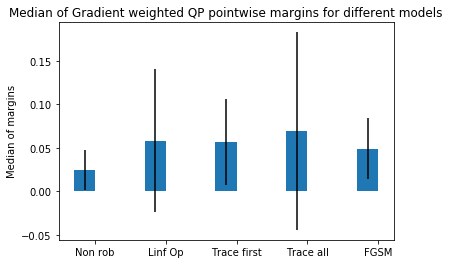

In [58]:
labels_margin = ['Non rob', 'Linf Op', 'Trace first', 'Trace all', 'FGSM']

x = 2*np.arange(len(labels_margin))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, margin_median, width, yerr = margin_std)
#rects2 = ax.bar(x + width/2, margins, width, label='margin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median of margins')
#ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
#ax.set_yscale('log')
ax.set_xticklabels(labels_margin)
ax.set_title("Median of Gradient weighted QP pointwise margins for different models")
#ax.legend()

plt.show()

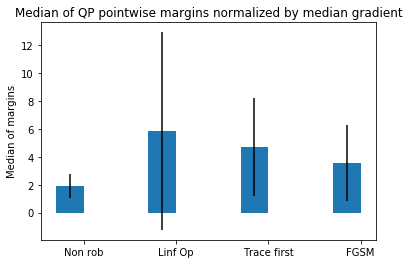

In [74]:
lip_list_big = [lip_non_rob, lip_trace_first_list, lip_trace_all_list, lip_op_list, lip_adv_list]

norm_factor = [lip_med[0], lip_med[-2], lip_med[1], lip_med[-1]]

margin_median_normalized = [margin_median[i]/norm_factor[i] for i in range(len(margin_means))]
margin_std_normalized = [margin_std[i]/norm_factor[i] for i in range(len(margin_std))]


x = 2*np.arange(len(labels_margin))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, margin_median_normalized , width, yerr = margin_std_normalized)
#rects2 = ax.bar(x + width/2, margins, width, label='margin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median of margins')
#ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
#ax.set_yscale('log')
ax.set_xticklabels(labels_margin)
ax.set_title("Median of QP pointwise margins normalized by median gradient")
#ax.legend()

plt.show()

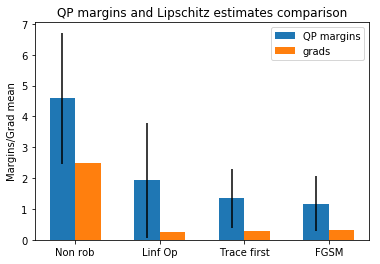

In [79]:
labels_margin = ['Non rob', 'Linf Op', 'Trace first', 'FGSM']

x = 2*np.arange(len(labels_margin))  # the label locations
width = 0.60  # the width of the bars

lip_90 = np.percentile(lip_list_big, 90, axis = 1).squeeze()
lip_10 = np.percentile(lip_list_big, 10, axis = 1).squeeze()
y_err_spec = [lip_med - lip_10, lip_90 - lip_med]



fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, margin_means, width, yerr = margin_std, label = 'QP margins')
rects2 = ax.bar(x + width/2, norm_factor, width, label='grads')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Margins/Grad mean')
#ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
#ax.set_yscale('log')
ax.set_xticklabels(labels_margin)
ax.set_title("QP margins and Lipschitz estimates comparison")
ax.legend()

plt.show()

# Complexities from papers

In [63]:
spectral_op_list, fr_op_list, lip_op_list = get_complexitites_many_models_reg(op_norm_models, sess_op_list, x_test_flat, y_test)
print('--')
spectral_non_rob, fr_non_rob, lip_non_rob = get_complexitites_many_models_reg(non_rob_models, non_rob_sess_list, x_test_flat, y_test)
print('--')
spectral_adv_list, fr_adv_list, lip_adv_list = get_complexitites_many_models_adv(adv_trained_models, adv_train_sess_list, x_test_flat, y_test)
print('--')
spectral_trace_all_list, fr_trace_all_list, lip_trace_all_list = get_complexitites_many_models_reg(trace_all_models, sess_trace_all_list, x_test_flat, y_test)
print('--')
spectral_trace_first_list, fr_trace_first_list, lip_trace_first_list = get_complexitites_many_models_reg(trace_first_models, sess_trace_first_list, x_test_flat, y_test)

0
Lip start
1
Lip start
2
Lip start
3
Lip start
4
Lip start
5
Lip start
6
Lip start
7
Lip start
--
0
Lip start
1
Lip start
2
Lip start
3
Lip start
4
Lip start
5
Lip start
6
Lip start
7
Lip start
--
0
Lip start
1
Lip start
2
Lip start
3
Lip start
4
Lip start
5
Lip start
6
Lip start
7
Lip start
--
0
Lip start
1
Lip start
2
Lip start
3
Lip start
4
Lip start
5
Lip start
6
Lip start
7
Lip start
--
0
Lip start
1
Lip start
2
Lip start
3
Lip start
4
Lip start
5
Lip start
6
Lip start
7
Lip start


In [ ]:
#fr_op_list

In [64]:
fr_list_big = [fr_non_rob, fr_trace_first_list, fr_trace_all_list, fr_op_list, fr_adv_list]
lip_list_big = [lip_non_rob, lip_trace_first_list, lip_trace_all_list, lip_op_list, lip_adv_list]
spectral_list_big = [spectral_non_rob, spectral_trace_first_list, spectral_trace_all_list, spectral_op_list, spectral_adv_list]

In [65]:
np.matrix(lip_list_big)

matrix([[3.0482    , 2.909826  , 2.3817182 , 2.089859  , 2.4274006 ,
         3.0664434 , 2.530584  , 2.4380856 ],
        [0.28118044, 0.2803161 , 0.3117437 , 0.24928346, 0.2568927 ,
         0.2828965 , 0.26177183, 0.25123817],
        [0.2104748 , 0.16247986, 0.2877156 , 0.23032458, 0.17662804,
         0.25105163, 0.19068277, 0.205375  ],
        [0.22210325, 0.37759265, 0.25982687, 0.363049  , 0.19321787,
         0.25230208, 0.31497237, 0.26453757],
        [0.32324684, 0.37276968, 0.29373997, 0.2911467 , 0.28699002,
         0.36321294, 0.32471943, 0.3612733 ]], dtype=float32)

In [66]:
fr_med = np.median(fr_list_big, axis = 1).squeeze()
lip_med = np.median(lip_list_big, axis = 1).squeeze()
spectral_med = np.median(spectral_list_big, axis = 1).squeeze()

In [ ]:
lip_med.shape

In [ ]:
#spectral_norm_list = [np.mean(spectral_non_rob), np.mean(spectral_trace_first_list), np.mean(spectral_trace_all_list), np.mean(spectral_op_list), np.mean(spectral_adv_list)]

In [ ]:
#fr_norm_list= [np.mean(fr_non_rob), np.mean(fr_trace_first_list), np.mean(fr_trace_all_list), np.mean(fr_op_list), np.mean(fr_adv_list)]

In [ ]:
labels = ['non_rob', 'trace_first', 'trace_all', 'linf op', 'fgsm']

In [ ]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

spec_90 = np.percentile(spectral_list_big, 90, axis = 1).squeeze()
spec_10 = np.percentile(spectral_list_big, 10, axis = 1).squeeze()
y_err_spec = [spectral_med - spec_10, spec_90 - spectral_med]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, spectral_med, width, yerr = y_err_spec)
#rects2 = ax.bar(x + width/2, margins, width, label='margin')
rects2 = ax.bar(x - width/2, spectral_mean_normalized, width, label='Spec')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('log(Spectral complexity)')
#ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(labels)
ax.legend()

plt.show()
print(spectral_med)

In [ ]:
aa

In [ ]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fr_90 = np.percentile(fr_list_big, 90, axis = 1).squeeze()
fr_10 = np.percentile(fr_list_big, 10, axis = 1).squeeze()
y_err = [fr_med - fr_10, fr_90 - fr_med]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fr_mean, width, yerr = y_err)
#rects2 = ax.bar(x + width/2, margins, width, label='margin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fisher rao norm')
#ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
#ax.set_yscale('log')
ax.set_xticklabels(labels)
ax.legend()

plt.show()
print(fr_mean)

In [ ]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

lip_90 = np.percentile(lip_list_big, 90, axis = 1).squeeze()
lip_10 = np.percentile(lip_list_big, 10, axis = 1).squeeze()
y_err_spec = [lip_med - lip_10, lip_90 - lip_med]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lip_mean, width, yerr = y_err_spec)
#rects2 = ax.bar(x + width/2, margins, width, label='margin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gradient Average')
#ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
#ax.set_yscale('log')
ax.set_xticklabels(labels)
ax.legend()

plt.show()
print(lip_mean)

In [ ]:
lip_mean_normalized = lip_mean/np.max(lip_mean)
fr_mean_normalized = fr_mean/np.max(fr_mean)
spectral_mean_normalized = spectral_mean/np.max(spectral_mean)

In [ ]:
"""
TODO: Make a combined bar chart.
"""
#lip_norm_list = np.mean(lip_list)

x = 2*np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - (3./2)*width, fr_mean_normalized, width, label='FR')
rects2 = ax.bar(x - width/2, spectral_mean_normalized, width, label='Spec')
rects3 = ax.bar(x + width/2, lip_mean_normalized, width, label='Grad')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Fisher rao norm')
#ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
#ax.set_yscale('log')
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# Accuracies w/ Error bars

In [ ]:
def acc_versus_eps_single_objective(model_list, sess_list, eps_list, scope_name = "model_non_robust", pgd = False):
    """
    Populates the matrix of acc versus eps models for all models of a given kind.
    And then returns the required order statistics for the plot.
    """
    
    accs_all_models = np.zeros((len(model_list), len(eps_list)))
    
    for model_idx, model in enumerate(model_list):
        sess = sess_list[model_idx]
        for (eps_idx, eps_test) in enumerate(eps_list):
            if not pgd:
                with tf.variable_scope(scope_name) as scope:
                    _, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
                    accs_all_models[model_idx][eps_idx] = acc_fgsm
    
    acc_med = np.median(accs_all_models, axis = 0)
    error_top = np.percentile(accs_all_models, 90, axis = 0) - acc_med
    error_bottom = acc_med - np.percentile(accs_all_models, 10, axis = 0)
    
    return acc_med, error_top, error_bottom, accs_all_models


def acc_versus_eps_single_objective_short(list_of_matrices, idx):
    """
    Populates the matrix of acc versus eps models for all models of a given kind.
    And then returns the required order statistics for the plot.
    """
    accs_all_models = list_of_matrices[idx]
    
    acc_med = np.median(accs_all_models, axis = 0)
    error_top = np.percentile(accs_all_models, 90, axis = 0) - acc_med
    error_bottom = acc_med - np.percentile(accs_all_models, 10, axis = 0)
    
    return acc_med, error_top, error_bottom, accs_all_models

def make_acc_vs_eps_plot_error_bars_short(list_all_matrices, legend_list, eps_list):
    fig = plt.figure()
    list_of_matrices = []
    
    for idx in range(len(list_all_matrices)):
        #sess_list = sess_list_big[idx]
        accs, error_top, error_bottom, matrix = acc_versus_eps_single_objective_short(list_all_matrices, idx)
        list_of_matrices.append(matrix)
        label = legend_list[idx]
        
        #ipdb.set_trace()
        plt.errorbar(eps_list, accs, yerr = [error_bottom, error_top], label = label)
    
    plt.legend()
    plt.show()
    return list_of_matrices

def make_acc_vs_eps_plot_error_bars(model_list_big, sess_list_big, eps_list, legend_list, scope_list, pgd = False):
    fig = plt.figure()
    list_of_matrices = []
    
    for idx, model_list in enumerate(model_list_big):
        sess_list = sess_list_big[idx]
        accs, error_top, error_bottom, matrix = acc_versus_eps_single_objective(model_list, sess_list, eps_list, scope_name = scope_list[idx])
        list_of_matrices.append(matrix)
        label = legend_list[idx]
        plt.errorbar(eps_list, accs, yerr = [error_bottom, error_top], label = label)
    
    plt.legend()
    plt.show()
    return list_of_matrices

In [ ]:
scope_list = ['model_non_robust']*8
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]

In [ ]:
model_list_big = [non_rob_models, trace_first_models, trace_all_models, op_norm_models, adv_trained_models]
sess_list_big = [non_rob_sess_list, sess_trace_first_list, sess_trace_all_list, sess_op_list, adv_train_sess_list]
scope_list = ['model_non_robust', 'model_non_robust', 'model_non_robust', 'model_non_robust', 'model_robust']
labels = ['non_rob', 'trace_first', 'trace_all', 'linf op', 'fgsm']

In [ ]:
list_all_matrices = make_acc_vs_eps_plot_error_bars(model_list_big, sess_list_big, eps_list, labels, scope_list)

In [ ]:
list_all_matrices = make_acc_vs_eps_plot_error_bars_short(list_all_matrices, labels, eps_list)

In [ ]:
non_rob_accs

# Black box perturbations w/ Error bars

In [ ]:
def make_plot_acc_vs_eps_black_box(model_list, sess_list, eps_list, angle_list, legend_list, scope_list):
    x_test_2d = np.array([vec.reshape((28,28)) for vec in x_test_flat])
    fig = plt.figure(figsize = (10,10))
    ax_gb = fig.add_subplot(2, 2, 1)
    ax_rp = fig.add_subplot(2, 2, 2)
    ax_bw = fig.add_subplot(2, 2, 3)
    ax_rot = fig.add_subplot(2, 2, 4)
    
    for idx, model in enumerate(model_list):
        sess = sess_list[idx]
        legend = legend_list[idx]
        gb_acc = []
        rp_acc = []
        bw_acc = []
        rot_acc = []
        
        scope_name = scope_list[idx]
        
        for (idx, eps_test) in enumerate(eps_list):
            x_test_gaussian_blurred = flatten_mnist(gaussian_blurring(x_test_2d, eps_test))[0]
            x_test_random_pert = flatten_mnist(random_perturbation(x_test_2d, eps_test))[0]
            x_test_black_white = flatten_mnist(random_blackout_whiteout(x_test_2d, eps_test))[0]
            angle = angle_list[idx]
            x_test_rot = flatten_mnist(rotate(x_test_2d, angle))[0]
            
            #ipdb.set_trace()
            gb_acc.append(model.evaluate(sess, x_test_gaussian_blurred, y_test)[1])
            rp_acc.append(model.evaluate(sess, x_test_random_pert, y_test)[1])
            bw_acc.append(model.evaluate(sess, x_test_black_white, y_test)[1])
            rot_acc.append(model.evaluate(sess, x_test_rot, y_test)[1])

        ax_gb.plot(eps_list, gb_acc, label = legend)
        ax_rp.plot(eps_list, rp_acc, label = legend)
        ax_bw.plot(eps_list, bw_acc, label = legend)
        ax_rot.plot(angle_list, rot_acc, label = legend)
 
    ax_gb.set_title("Gaussian blurring")
    ax_rp.set_title("Random perturbation")
    ax_bw.set_title("Blackwhite")
    ax_rot.set_title("Rotation")
    
    plt.legend(loc = (2.5, 0.7))
    plt.show()
    return True

In [ ]:
"""
Error bars for black box perturbations
"""
def acc_versus_eps_single_objective_single_perturbation(model_list, sess_list, eps_list, perturbation_func, scope_name):
    print("----New model objective---")
    x_test_2d = np.array([vec.reshape((28,28)) for vec in x_test_flat])
    accs_all_models = np.zeros((len(model_list), len(eps_list)))
    
    for model_idx, model in enumerate(model_list):
        sess = sess_list[model_idx]
        for (eps_idx, eps_test) in enumerate(eps_list):
            with tf.variable_scope(scope_name) as scope:
                x_test_perturbed = flatten_mnist(perturbation_func(x_test_2d, eps_test))[0]
                acc_perturbed = model.evaluate(sess, x_test_perturbed, y_test)[1]
                accs_all_models[model_idx][eps_idx] = acc_perturbed
    
    acc_med = np.median(accs_all_models, axis = 0)
    error_top = np.percentile(accs_all_models, 90, axis = 0) - acc_med
    error_bottom = acc_med - np.percentile(accs_all_models, 10, axis = 0)
    return acc_med, error_top, error_bottom, accs_all_models
    
def make_acc_vs_eps_plot_error_bars_black_box(model_list_big, sess_list_big, eps_list_big, legend_list, scope_list, perturbation_func_list):
    dict_pert_to_matrix_list = {}
    for (i, perturbation_func) in enumerate(perturbation_func_list):
        eps_list = eps_list_big[i]
        fig = plt.figure()
        print("---New pert func---")
        matrix_list = []

        for idx, model_list in enumerate(model_list_big):
            sess_list = sess_list_big[idx]
            accs, error_top, error_bottom, matrix = acc_versus_eps_single_objective_single_perturbation(model_list, sess_list, eps_list, perturbation_func, scope_name = scope_list[idx])
            label = legend_list[idx]
            plt.errorbar(eps_list, accs, yerr = [error_bottom, error_top], label = label)
            matrix_list.append(matrix)
        
        dict_pert_to_matrix_list[str(perturbation_func)] = matrix_list
        
        plt.title(perturbation_func)
        plt.legend()
        plt.show()
    
    return dict_pert_to_matrix_list

In [ ]:
#perturbation_func_list = [gaussian_blurring, random_perturbation, random_blackout_whiteout, rotate]
perturbation_func_list = [rotate]
eps_list =  [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
angle_list = [10, 15, 20, 25, 30, 35, 40]
#eps_list_big = [eps_list]*3 + [[angle_list]]
eps_list_big = [angle_list]

In [ ]:
map_from_pert_to_results = make_acc_vs_eps_plot_error_bars_black_box(model_list_big, sess_list_big, eps_list_big, labels, scope_list, perturbation_func_list)

In [ ]:
aa

In [ ]:
list_of_mat = map_from_pert_to_results[str(rotate)]

In [ ]:
acc = np.median(list_of_mat[2], axis = 0))
error_top = np.percentile(list_of_mat[2], 90, axis = 0)) - acc
error_bottom = np.percentile(list_of_mat[2], 10, axis = 0)) - 

## Distances

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
#make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order = 2)

In [ ]:
#make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order = float("inf"))

## Stats

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]

In [ ]:
reg_evals, adv_evals, margins, dphi_dxs = get_stats_all_models(model_list, sess_list, scope_list)

In [ ]:
#model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model

In [ ]:
reg_evals

In [ ]:
adv_evals

In [ ]:
dphi_dxs

In [ ]:
margins

In [ ]:
labels = ['non robust', 'Sing val all', 'fgsm train', 'hybrid', 'sing val first']

In [ ]:
adv_evals_np = np.array(adv_evals)
acc_adv = adv_evals_np[:, 1]

In [ ]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dphi_dxs, width, label='dphi_dx')
rects2 = ax.bar(x + width/2, margins, width, label='margin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Margins/ Gradient means')
ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
print(adv_evals_np[:, 1])

In [ ]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dphi_dxs, width, label='dphi_dx')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gradient means')
ax.set_ylim((0, 1.1))
ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


color = 'tab:orange'
ax2 = ax.twinx()
rects2 = ax2.bar(x + width/2, margins, width, label='margin', color = color)
ax2.set_ylabel('Margins')
ax2.set_ylim((0, 0.40))
#ax.set_xticks(x)
#ax.set_xticklabels(labels)
#ax2.legend(legend_loc = (1.0, 0.8))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for (idx, rect) in enumerate(rects1):
        height = rect.get_height()
        height_2 = rects2[idx].get_height() * (1.0/0.37)
        height = max(height, height_2)
        ax.annotate('{:0.3f}'.format(acc_adv[idx]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()
print(adv_evals_np[:, 1])

## Accuracies 

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
#make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = False)

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = True)

## Black box accuracies

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
angle_list = [10, 15, 20, 25, 30, 35, 40]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
make_plot_acc_vs_eps_black_box(model_list, sess_list, eps_list, angle_list, legend_list, scope_list)

## Singular Values 

In [ ]:
norm_factor_non = sing_vals[0][0]
sing_non = sing_vals[0]/norm_factor_non
norm_factor_rob = sing_vals_robust[0][0]
sing_rob = sing_vals_robust[0]/norm_factor_rob

plt.loglog(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.loglog(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.semilogy(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.semilogy(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.plot(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.plot(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
def all_plots_layer_k(k):
    norm_factor_non = sing_vals[k][0]
    print("-----NORM FACTOR NON---")
    print(norm_factor_non)
    sing_non = sing_vals[k]/norm_factor_non
    norm_factor_rob = sing_vals_robust[k][0]
    print("-----NORM FACTOR ROB---")
    print(norm_factor_rob)
    sing_rob = sing_vals_robust[k]/norm_factor_rob
    plt.loglog(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.loglog(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.semilogy(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.semilogy(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.plot(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.plot(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()

In [ ]:
num_layers = len(sing_vals)

In [ ]:
num_layers

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")